In [1]:
import matplotlib.pyplot as plt
import numpy as np
import umap
import imageio
import os
from tqdm import trange
from sklearn.manifold import TSNE

In [157]:
np.load('offline_node_real0.npy')

array([-373.23, -454.99, -373.46, -227.87, -234.65, -275.97, -249.67,
       -219.72, -228.62, -184.88, -197.82, -189.09, -193.78, -195.4 ,
       -206.1 , -174.19, -188.31, -186.82, -188.17, -186.62, -196.14,
       -211.3 , -177.94, -214.96, -186.58, -188.97, -200.73, -210.74,
       -200.23, -233.36, -196.55, -203.91, -184.93, -225.64, -202.5 ,
       -209.91, -188.68, -207.12, -209.99, -207.23, -216.12, -244.21,
       -222.07, -241.73, -192.14, -215.4 , -211.09, -232.9 , -214.47,
       -242.3 , -229.95, -218.23, -241.43, -238.84, -224.73, -244.6 ,
       -219.51, -239.76, -217.9 , -264.4 , -238.8 , -209.93, -232.82,
       -225.21, -228.38, -210.24, -230.83, -233.07, -250.62, -229.68,
       -225.53, -209.4 , -230.23, -251.06, -234.52, -225.2 , -230.18,
       -196.66, -227.77, -229.57, -230.43, -222.26, -227.94, -225.89,
       -213.79, -236.33, -209.92, -232.13, -230.8 , -203.09, -218.57,
       -224.67, -227.92, -213.89, -218.71, -217.16, -229.93, -209.14,
       -219.85, -235

(0.0, 50.0)

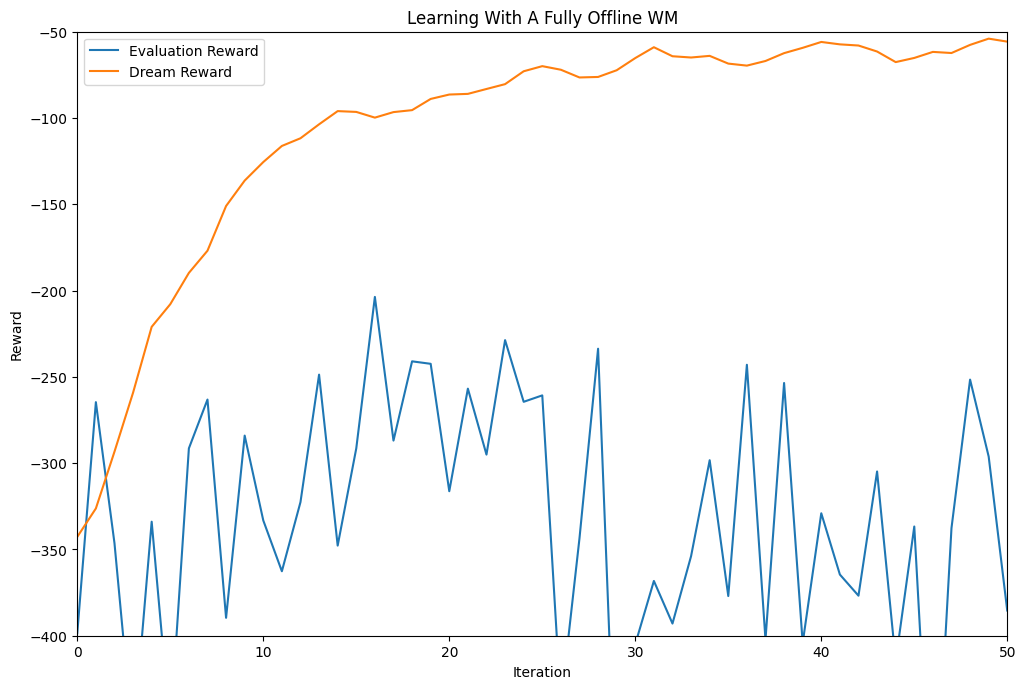

In [8]:
fig = plt.figure(figsize=(12, 8), dpi=100)

plt.plot(np.load('offline_node_real0.npy'), label="Evaluation Reward")
plt.plot(np.load('offline_node_dream0.npy'), label="Dream Reward") 

plt.legend()
plt.title('Learning With A Fully Offline WM')
plt.xlabel('Iteration')
plt.ylabel('Reward')
plt.ylim(-400, -50)
plt.xlim(0, 50)

In [3]:
mean = np.zeros((5,60))
for i in range(5):
    mean[i,:] = np.load('baseline' + str(i) + '.npy')
mean = mean.mean(axis=0)

mean_40 = np.zeros((4,50))
for i in range(4):
    mean_40[i,:] = np.load('40_seq_lim_mem' + str(i) + '.npy')
mean_40 = mean_40.mean(axis=0)

mean_30 = np.zeros((4,50))
for i in range(4):
    mean_30[i,:] = np.load('30_seq_lim_mem' + str(i) + '.npy')
mean_30 = mean_30.mean(axis=0)

mean_40_2 = np.zeros((4,50))
ind = 0
for i in range(5):
    if i == 1: continue
    mean_40_2[ind,:45] = np.load('40_seq_lim_mem_4000_dream' + str(i) + '.npy')[0:45]
    ind += 1
mean_40_2 = mean_40_2.mean(axis=0)

In [2]:
np.load('ppo_meander' + str(i) + '.npy').shape

NameError: name 'i' is not defined

In [6]:
mean_m = np.zeros((5,100))
for i in range(5):
    mean_m[i,:] = np.load('baseline_meander' + str(i) + '.npy')
mean_m = mean_m.mean(axis=0)

In [162]:
t = np.zeros(50)
t[0:45] = np.load('40_seq_lim_mem_4000_dream3.npy')
np.save('40_seq_lim_mem_4000_dream3.npy', t)

ValueError: could not broadcast input array from shape (50,) into shape (45,)

(15.0, 49.0)

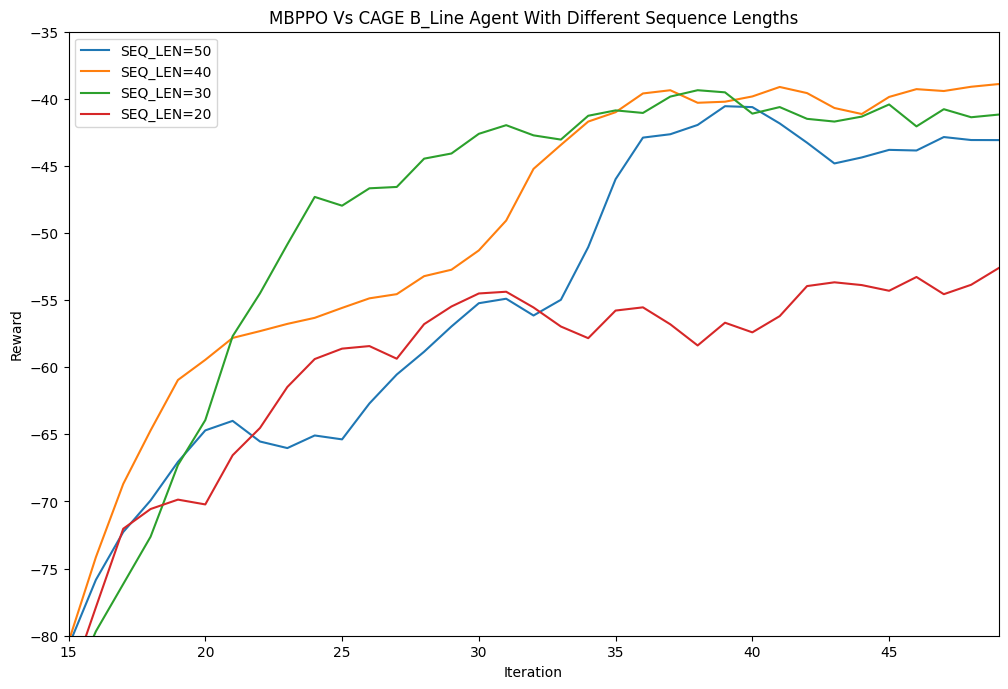

: 

In [106]:
fig = plt.figure(figsize=(12, 8), dpi=100)

#plt.plot(np.load('node_priv_unk_lstm0.npy'), label="loss fix0")
#plt.plot(np.load('node_priv_unk_lstm1.npy'), label="loss fix1")
#plt.plot(np.load('node_priv_unk_lstm2.npy'), label="loss fix2")
#plt.plot(np.load('node_priv_unk_lstm3.npy'), label="loss fix3")

#plt.plot(np.load('node_feedforward_seq_reward0.npy'), label="node_state_action_reward0")
#plt.plot(np.load('node_feedforward_seq_reward1.npy'), label="node_state_action_reward0")

#plt.plot(np.load('working_maybe0.npy'), label="SEQ=40")

plt.plot(np.load('50_seq_lim_mem1.npy'), label="SEQ_LEN=50")
plt.plot(np.arange(1,51), np.load('40_seq_lim_mem_4000_dream2.npy'), label="SEQ_LEN=40")
plt.plot(np.load('30_seq_lim_mem2.npy'), label="SEQ_LEN=30")
plt.plot(np.load('20_seq_lim_mem1.npy'), label="SEQ_LEN=20")


#plt.plot(np.load('node_id_branch3.npy'), label="Result 3")
#plt.plot(np.load('node_id_branch4.npy'), label="Result 4")
#plt.plot(np.load('node_validation1.npy'), label="Result 5")

#plt.plot(np.load('node_state_action_reward3.npy'), label="node_state_action_reward3")
#plt.plot(np.load('node_priv_unk_lstm5.npy'), label="loss fix5")
#plt.plot(np.load('node_priv_unk_lstm6.npy'), label="loss fix6")

plt.legend()
plt.title('MBPPO Vs CAGE B_Line Agent With Different Sequence Lengths')
plt.xlabel('Iteration')
plt.ylabel('Reward')
plt.ylim(-80, -35)
plt.xlim(15, 49)

In [41]:
t =  np.mean(np.load('dqn_bline_baseline_0.npy').reshape(-1, 4), axis=1)
t.shape

(55,)

In [94]:
mean_dqn = np.zeros((5,56))
for i in range(5):
    mean_dqn[i,:][1:] = np.mean(np.load('dqn_bline_baseline_'+str(i)+'.npy').reshape(-1, 4), axis=1)
    print(np.argmax(mean_dqn[i,1:]>-39))
max_dqn = mean_dqn.max(axis=0)
min_dqn  = mean_dqn.min(axis=0)
mean_dqn = mean_dqn.mean(axis=0)

50
0
0
0
0


In [89]:
250/4

62.5

In [92]:
mean_dqn2 = np.zeros((5,63))
for i in range(5):
    mean_dqn2[i,:][1:] = np.mean(np.load('2dqn_bline_baseline_'+str(i)+'.npy')[0:248].reshape(-1, 4), axis=1)
    print(np.argmax(mean_dqn2[i,1:]>-39))
max_dqn2 = mean_dqn2.max(axis=0)
min_dqn2  = mean_dqn2.min(axis=0)
mean_dqn2 = mean_dqn2.mean(axis=0)

56
0
58
0
50


In [101]:

t = np.load('40_seq_lim_mem_4000_dream4.npy')
print(t)
t[49] = -37.2
t
np.save('40_seq_lim_mem_4000_dream4.npy', t)

[-370.95  -359.945 -294.821 -237.918 -195.041 -178.787 -168.134 -152.484
 -146.633 -135.819 -125.542 -109.208  -95.429  -86.336  -79.871  -74.456
  -69.138  -67.476  -65.881  -66.52   -63.781  -62.481  -61.929  -61.003
  -60.482  -60.176  -58.384  -54.745  -49.892  -46.103  -44.102  -43.152
  -42.038  -42.553  -41.299  -40.452  -39.684  -39.369  -40.556  -40.339
  -39.8    -39.386  -38.804  -39.403  -38.953  -38.763  -38.263  -38.163
  -38.263  -38.763]


In [88]:
for i in range(5):
    #if i == 1: continue
    mean_40_2_[i,1:46] = np.load('40_seq_lim_mem_4000_dream' + str(i) + '.npy')[0:50]
    print(np.argmax(mean_40_2_[i,1:]>-39))

(50,)
(50,)
(50,)
(50,)
(50,)


39
40
0
39
0

41
35
48
35
42


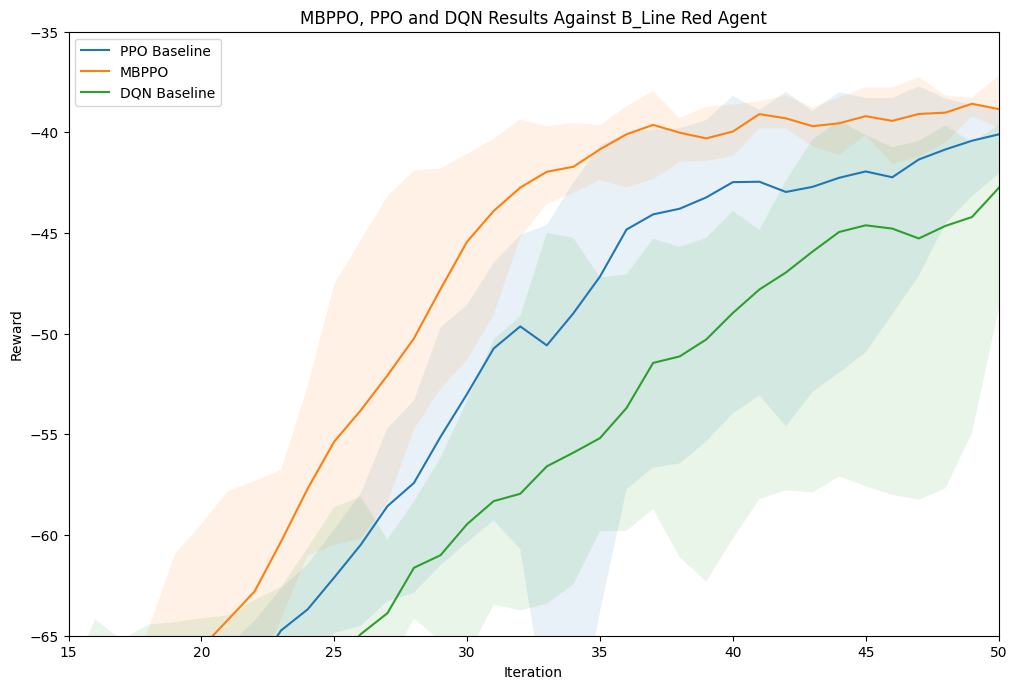

In [97]:
mean_ = np.zeros((5,61))
for i in range(5):
    mean_[i,:][1:] = np.load('baseline' + str(i) + '.npy')
    print(np.argmax(mean_[i,1:]>-39))
mean = mean_.mean(axis=0)
median = np.median(mean_, axis=0)
max_ = mean_.max(axis=0)
min_ = mean_.min(axis=0)
print('')

mean_40_2_ = np.zeros((5,51))
ind = 0
for i in range(5):
    #if i == 1: continue
    mean_40_2_[i,1:] = np.load('40_seq_lim_mem_4000_dream' + str(i) + '.npy')
    print(np.argmax(mean_40_2_[i,1:]>-39))

mean_40_2 = mean_40_2_.mean(axis=0)
median_40_2 = np.median(mean_40_2_, axis=0)
max__ = mean_40_2_.max(axis=0)
min__ = mean_40_2_.min(axis=0)

fig = plt.figure(figsize=(12, 8), dpi=100)
plt.plot(mean[0:], label="PPO Baseline")

plt.plot(mean_40_2, label="MBPPO")
#plt.plot(median_40_2, label="MBPPO med")

plt.plot(mean_dqn2, label="DQN Baseline")

plt.legend()
plt.title('MBPPO, PPO and DQN Results Against B_Line Red Agent')
plt.xlabel('Iteration')
plt.ylabel('Reward')
plt.ylim(-65, -35)
plt.xlim(15, 50)



plt.fill_between(np.arange(0,61), min_, max_, alpha=0.1)
plt.fill_between(np.arange(0,51), min__, max__, alpha=0.1)
plt.fill_between(np.arange(0,63), min_dqn2, max_dqn2, alpha=0.1)

In [ ]:
t = np.load('40_seq_lim_mem_4000_dream1.npy')
t = np.roll(t, -2)
t[43] = -38.263
t[44] = -37.763
np.save('40_seq_lim_mem_4000_dream1.npy', t)

In [67]:
np.max(np.load('mbppo_80_meander_80000.npy'))

-59.54700000000008

In [68]:
-59.547 - -55.858

-3.689

In [66]:
for i in range(5):
  print(np.max(np.load('baseline_meander' + str(i) + '.npy')))

-65.36200000000002
-61.690000000000055
-59.61800000000006
-59.865000000000066
-55.858000000000054


(10.0, 99.0)

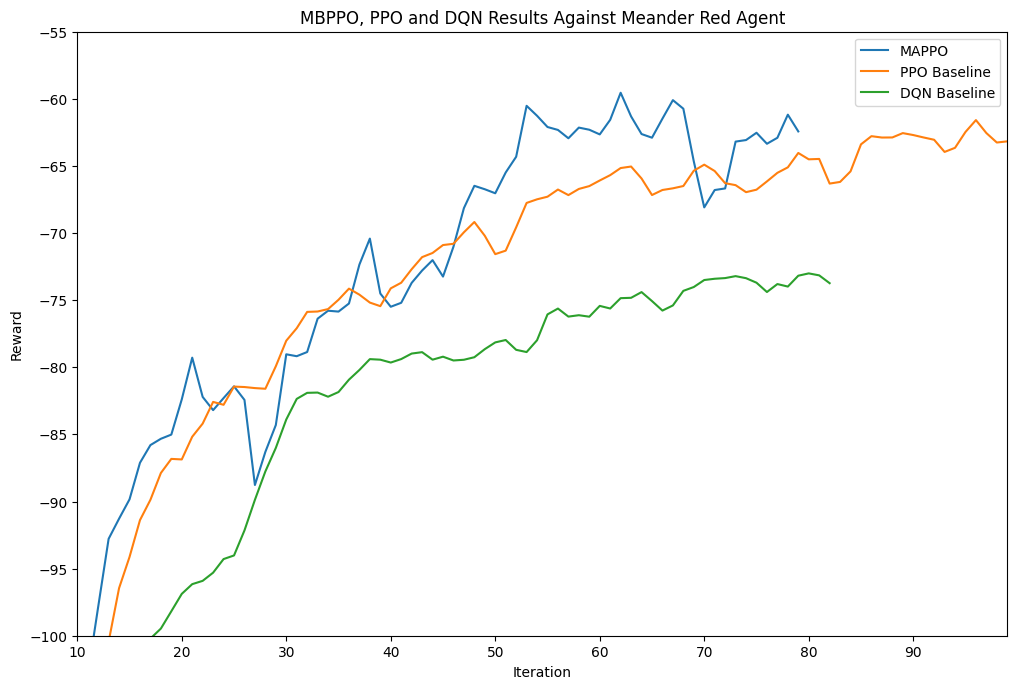

In [64]:
fig = plt.figure(figsize=(12, 8), dpi=100)
plt.plot(np.load('mbppo_80_meander_80000.npy'), label='MAPPO')


mean_dqn = np.zeros((4,83))
for i in range(4):
    mean_dqn[i,:][1:] = np.mean(np.load('dqn_bline_meander_'+str(i)+'.npy')[:328].reshape(-1, 4), axis=1)

mean_dqn_ = np.zeros((5,83))
for i in range(5):
    mean_dqn_[i,:][1:] = np.mean(np.load('dqn_meander_baseline_'+str(i)+'.npy')[:328].reshape(-1, 4), axis=1)

plt.plot(mean_m, label='PPO Baseline')

plt.plot(np.mean(mean_dqn, axis=0), label='DQN Baseline')

plt.legend()
plt.title('MBPPO, PPO and DQN Results Against Meander Red Agent')
plt.xlabel('Iteration')
plt.ylabel('Reward')
plt.ylim(-100, -55)
plt.xlim(10, 99)

In [4]:
import pandas as pd
df = pd.read_csv('ood.csv', sep=',', header=None)
df.values[0,1] = -101


In [ ]:
w = np.array([422.4,375.5,334.5,274.7,214.4,190.6,177.2, 165.5, 159.0, 148.9, 137.8, 127.5, 119.7, 109.4, 98.7,
              94.8, 88.1, 81.4, 74.7, 72.4, 68.8, 68.9, 68.7,67.6,65.3,62,59.9,57.8,52.8,46.3,45.7,46.1,44.9,42.7,42.8,42.2,41.4,41.8,41.8,41.3,40.4,40,40,39.6,39.3,40.4,41.0,40.7,39,39.8,40.3,40.1,39.4,37.9,37.5,38.5,38,37.7,37.7,37.7])

np.save('working_maybe0.npy', -w)

In [ ]:
np.random.choice(np.arange(3), p=[0.5,0.25,0.25])

1

In [ ]:
mean_ = []
mean_.append(np.load('node_with_priv0.npy'))
mean_.append(np.load('node_with_priv1.npy'))
mean_.append(np.load('node_with_priv2.npy'))
mean_.append(np.load('node_with_priv3.npy'))
mean_ = np.array(mean_)
mean_ = np.mean(mean_, axis=1)
mean_

NameError: name 'np' is not defined

In [31]:
from os import listdir
from os.path import isfile, join
path = '/home/adamprice/u75a-Data-Efficient-Decisions/CybORG/CybORG/MBPPO/batch_encodings_OOD/'
onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]
batches = {}
for f in onlyfiles:
    index = int(f.split('_')[-1].split('.')[0])
    if index < 80000: continue
    if index > 280000: continue
    if f.split('_')[0] == 'dream': index += 1
    batches[index] = np.load(path + f)

keys = list(batches.keys())
keys.sort()
batches = {i: batches[i] for i in keys}

real_map = []; dream_map = []
for i, k in enumerate(list(batches.keys())):
    if k % 2 == 0:
        real_map.append(i)
    else:
        dream_map.append(i)
batch_array = np.array((list(batches.values())))

real_map_array = np.array(real_map, dtype=np.int16)
dream_map_array = np.array(dream_map, dtype=np.int16)

In [32]:
from os import listdir
from os.path import isfile, join
path = '/home/adamprice/u75a-Data-Efficient-Decisions/CybORG/CybORG/MBPPO/batch_encodings/'
onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]
batches = {}
for f in onlyfiles:
    index = int(f.split('_')[-1].split('.')[0])
    if index < 80000: continue
    if index > 280000: continue
    if f.split('_')[0] == 'dream': index += 1
    batches[index] = np.load(path + f)

keys = list(batches.keys())
keys.sort()
batches = {i: batches[i] for i in keys}

real_map_ = []; dream_map_ = []
for i, k in enumerate(list(batches.keys())):
    if k % 2 == 0:
        real_map_.append(i+len(real_map)+len(dream_map)) 
    else:
        dream_map_.append(i+len(real_map)+len(dream_map))
batch_array_ = np.array((list(batches.values())))

real_map_array = np.array(real_map_, dtype=np.int16)
dream_map_array = np.array(dream_map_, dtype=np.int16)

In [33]:
len(real_map_)

51

In [34]:
#reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1)
#embedding = reducer.fit_transform(batch_array)
embedding = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(np.concatenate([batch_array[:,:], batch_array_[:,:]]))

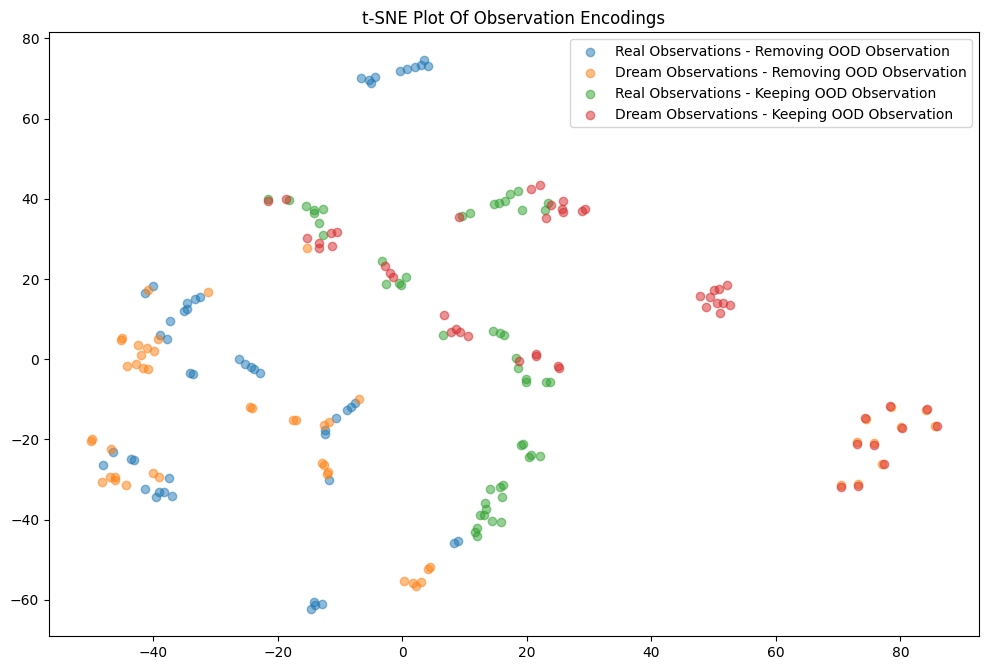

In [35]:
fig = plt.figure(figsize=(12, 8), dpi=100)
plt.title('t-SNE Plot Of Observation Encodings')
plt.scatter(embedding[real_map][:,0], embedding[real_map][:,1], alpha=0.5, label = 'Real Observations - Removing OOD Observation')
plt.scatter(embedding[dream_map][:,0], embedding[dream_map][:,1], alpha=0.5, label = 'Dream Observations - Removing OOD Observation')

plt.scatter(embedding[real_map_][:,0], embedding[real_map_][:,1], alpha=0.5, label = 'Real Observations - Keeping OOD Observation')
plt.scatter(embedding[dream_map_][:,0], embedding[dream_map_][:,1], alpha=0.5, label = 'Dream Observations - Keeping OOD Observation')

plt.legend(loc=0)

In [39]:

path = 'gagif2'
if not os.path.exists('gagif2'):
    os.mkdir(path)
#Comment out umap_embedding if adjusting plots after first run, its non-determeisitic 

filenames = []
for i in trange(batch_array.shape[0]): 
    fig = plt.figure(figsize=(12, 8), dpi=100)
    plt.xlim([-60,90])
    plt.ylim([-66,80])
    plt.title('t-SNE Plot Of Observation Encodings')
    plt.scatter(embedding[real_map][:i,0], embedding[real_map][:i,1], alpha=0.5, label = 'Real Observations - Removing OOD Observation')
    plt.scatter(embedding[dream_map][:i,0], embedding[dream_map][:i,1], alpha=0.5, label = 'Dream Observations - Removing OOD Observation')

    plt.scatter(embedding[real_map_][:i,0], embedding[real_map_][:i,1], alpha=0.5, label = 'Real Observations - Keeping OOD Observation')
    plt.scatter(embedding[dream_map_][:i,0], embedding[dream_map_][:i,1], alpha=0.5, label = 'Dream Observations - Keeping OOD Observation')

    plt.legend(loc=1)
    plt.savefig(path+'/'+str(i)+'.png')
    filenames.append(path+'/'+str(i)+'.png')
    plt.close()

images = []
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('t-sne.gif', images, duration=5)

100%|██████████| 101/101 [00:32<00:00,  3.10it/s]
/tmp/ipykernel_35691/538702694.py:25: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


(70,)


(29.0, 95.0)

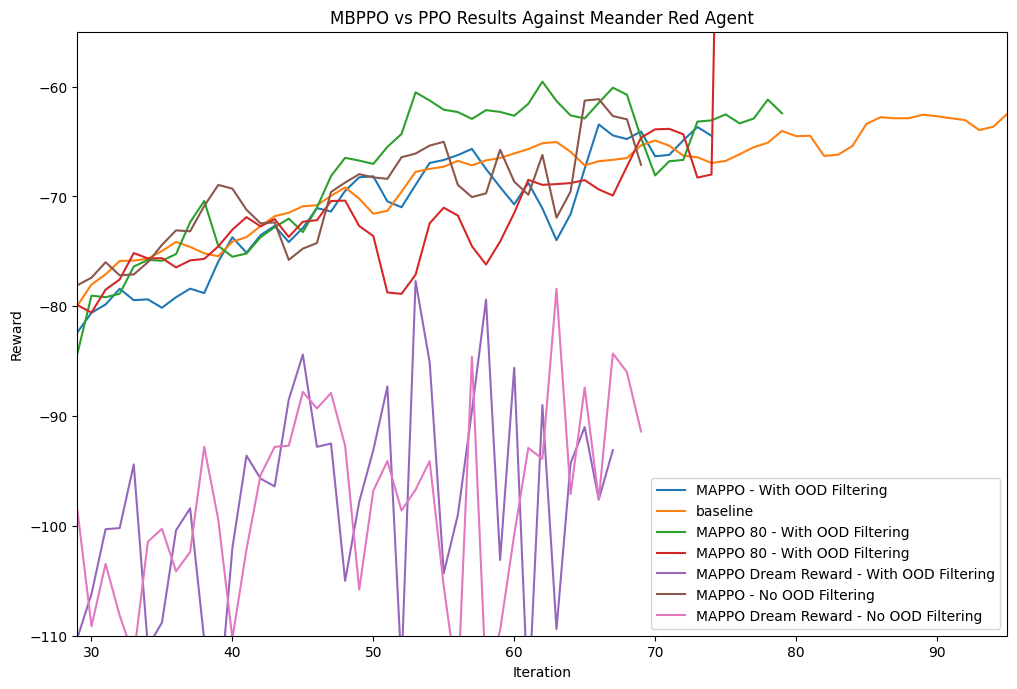

In [10]:
fig = plt.figure(figsize=(12, 8), dpi=100)
plt.plot(np.load('mbppo_70_meander_100000.npy'), label='MAPPO - With OOD Filtering')
ood = np.concatenate([np.ones(12)*-200, df.values[:,1]])
print(ood.shape)

plt.plot(mean_m, label='baseline')
plt.plot(np.load('mbppo_80_meander_80000.npy'), label='MAPPO 80 - With OOD Filtering')
plt.plot(np.load('mbppo_80_meander_80001.npy'), label='MAPPO 80 - With OOD Filtering')

#78
dr = [-110.2, -106.2, -100.3,-100.2,-94.4,-111,-108.8,-100.4,-98.4,-110.4,-117,-102,-93.6,-95.7,-96.4,-88.5,-84.4,-92.8,-92.5,-105,-97.8,
      -93.1,-87.3,-113,-77.7,-85.1, -104.3, -99, -89.5, -79.4, -103.1, -85.6, -116.4, -89, -109.4, -94.3, -91.0, -97.6, -93.1,
      ]
dr = [item for item in dr]
plt.plot(np.arange(29, 29+len(dr)), dr, label='MAPPO Dream Reward - With OOD Filtering')


plt.plot(ood, label='MAPPO - No OOD Filtering')

dr = [-98.55, -109.14, -103.46, -108.16, -111.90, -101.44, -100.26, -104.13, -102.38, -92.8, -99.44, -110.26, -102.13, -95.38, -92.8, -92.7, -87.8, -89.3, -87.9, -92.7, -105.8, -96.8, -94.1, -98.6, -96.7, -94.1, -105.5, -114.8, -84.6, -114.2, -109.5, -100.8, -92.9, -93.9, -78.4, -97.1, -87.4, -97.6, -84.3, -86.0, -91.4]
plt.plot(np.arange(29, 70), dr, label='MAPPO Dream Reward - No OOD Filtering')


mean_dqn = np.zeros((4,83))
for i in range(4):
    mean_dqn[i,:][1:] = np.mean(np.load('dqn_bline_meander_'+str(i)+'.npy')[:328].reshape(-1, 4), axis=1)

plt.legend()
plt.title('MBPPO vs PPO Results Against Meander Red Agent')
plt.xlabel('Iteration')
plt.ylabel('Reward')
plt.ylim(-110, -55)
plt.xlim(29, 95)

In [11]:
path = '/home/adamprice/u75a-Data-Efficient-Decisions/CybORG/CybORG/MBPPO/batch_encodings/'
print('Spread from Real:')
cate = ['exploit', 'scan', 'no_activity', 'privileged', 'user', 'unknown', 'no comp']
a = np.load(path+'/obs_128000.npy')
for i in range(7):
    print(cate[i], np.mean(a[np.arange(i,91,step=7)]))


Spread from Real:
exploit 0.033653844
scan 0.045403846
no_activity 0.92094225
privileged 0.053903844
user 0.2278846
unknown 0.08173077
no comp 0.63648075


In [6]:
print('Spread from Dream:')
cate = ['exploit', 'scan', 'no_activity', 'privileged', 'user', 'unknown', 'no comp']
a = np.load(path+'/dream_obs_228000.npy')
for i in range(7):
    print(cate[i], np.mean((a[np.arange(i,91,step=7)])))

Spread from Dream:


NameError: name 'path' is not defined

In [ ]:
t = np.zeros(10).reshape((2,5))
t2  = np.zeros(10).reshape((2,5))

In [ ]:
t = np.arange(1,3)
rewards = np.zeros((2,10))
rewards[:,5] = t
rewards



array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 2., 0., 0., 0., 0.]])

In [ ]:
def normalized(x):
    return (x-np.min(x))/(np.max(x)-np.min(x))

In [ ]:
a = np.load(path+'/obs_148000.npy')
for i in range(13):
    print(a[i*7:(i+1)*7])

FileNotFoundError: [Errno 2] No such file or directory: '/home/adamprice/u75a-Data-Efficient-Decisions/CybORG/CybORG/MBPPO/batch_encodings//obs_148000.npy'

In [ ]:
a = np.load(path+'/dream_obs_148000.npy')
for i in range(13):
    print(a[i*7:(i+1)*7])

[0. 0. 1. 0. 0. 0. 1.]
[0.08809524 0.07333333 0.83857143 0.         0.12952381 0.
 0.87047619]
[1.85714286e-02 6.66666667e-02 9.14761905e-01 9.52380952e-04
 2.61904762e-02 0.00000000e+00 9.72857143e-01]
[0.10666667 0.11714286 0.77619048 0.05904762 0.15285714 0.00190476
 0.78619048]
[0. 0. 1. 0. 0. 0. 1.]
[0. 0. 1. 0. 0. 0. 1.]
[0. 0. 1. 0. 0. 0. 1.]
[0.00238095 0.01238095 0.9852381  0.0052381  0.02714286 0.
 0.96761905]
[0.        0.0447619 0.9552381 0.        0.        0.        1.       ]
[0.00666667 0.04904762 0.94428571 0.00333333 0.05761905 0.03142857
 0.90761905]
[0.00904762 0.06190476 0.92904762 0.04190476 0.09952381 0.06666667
 0.79190476]
[0.00380952 0.04619048 0.95       0.05857143 0.06952381 0.
 0.87190476]
[0.01904762 0.06857143 0.91238095 0.         0.38809524 0.0547619
 0.55714286]


In [ ]:
np.set_printoptions(suppress=True)


In [ ]:
np.load('pred_fix0.npy')

array([-465.9375 , -419.26625, -358.33   , -263.351  , -227.686  ,
       -199.109  , -187.476  , -179.946  , -162.826  , -154.879  ,
       -145.17   , -134.068  , -122.316  , -109.72   ,  -97.175  ,
        -90.803  ,  -85.475  ,  -78.77   ,  -73.449  ,  -69.242  ,
        -68.337  ,  -67.919  ,  -67.352  ,  -63.411  ,  -62.319  ,
        -63.01   ,  -62.675  ,  -61.399  ,  -59.005  ,  -58.405  ,
        -59.099  ,  -59.393  ,  -59.845  ,  -56.684  ,  -55.662  ,
        -53.848  ,  -50.995  ,  -46.728  ,  -43.858  ,  -42.47   ,
        -43.491  ,  -45.103  ,  -43.873  ,  -45.832  ,  -43.747  ,
        -42.508  ,  -39.444  ,  -39.498  ,  -42.642  ,  -45.086  ,
        -44.028  ,  -39.672  ,  -39.457  ,  -39.533  ,  -40.342  ,
        -39.673  ,    0.     ,    0.     ,    0.     ,    0.     ,
          0.     ,    0.     ,    0.     ,    0.     ,    0.     ,
          0.     ,    0.     ,    0.     ,    0.     ,    0.     ,
          0.     ,    0.     ,    0.     ,    0.     ,    0.  

In [27]:

path = 'gagif'
if not os.path.exists('gagif'):
    os.mkdir(path)
#Comment out umap_embedding if adjusting plots after first run, its non-determeisitic 

obs_based_reward = np.load('mbppo_50_meander_invalids0.npy')

dream_pnt = 0; real_pnt = 0
filenames = []
for i in trange(batch_array.shape[0]): 
    fig = plt.figure(figsize=(12, 8), dpi=100)
    
    ax = plt.subplot(1, 2, 1)
    ax.set_xlim([embedding[:,0].min()-2,embedding[:,0].max()+2])
    ax.set_ylim([embedding[:,1].min()-2,embedding[:,1].max()+2]) 
    ax.set_title('t-SNE plot of Batch Observation Embedding')
    ax1 = plt.subplot(1, 2, 2)
    ax1.set_xlim([0,54])
    ax1.set_ylim([-100,-60])
    ax1.set_title('Reward Accumilation')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Reward')
    ax1.plot(obs_based_reward[:real_pnt], label="MBPPO - SEQ_LEN 40")
    plt.plot(mean_m, label="PPO Baseline")
    #ax1.plot(mean_m[:i_line+1], label="PPO - Evaluation")
    ax1.legend(loc='lower right')

    if i in real_map:
        real_pnt += 1
    else:
        dream_pnt += 1

    ax.scatter(embedding[real_map_array[:real_pnt]][:,0], embedding[real_map_array[:real_pnt]][:,1], alpha=0.5, label = 'Real')
    ax.scatter(embedding[dream_map_array[:dream_pnt]][:,0], embedding[dream_map_array[:dream_pnt]][:,1], alpha=0.5, label = 'Dream')
    ax.legend()
    plt.savefig(path+'/'+str(i)+'.png')
    filenames.append(path+'/'+str(i)+'.png')
    plt.close()

images = []
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('worldmodel_training.gif', images, duration=0.2)

100%|██████████| 89/89 [00:40<00:00,  2.22it/s]
/tmp/ipykernel_25449/1158905705.py:42: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


In [ ]:
imageio.mimsave('worldmodel_training.gif', images, duration=0.3)

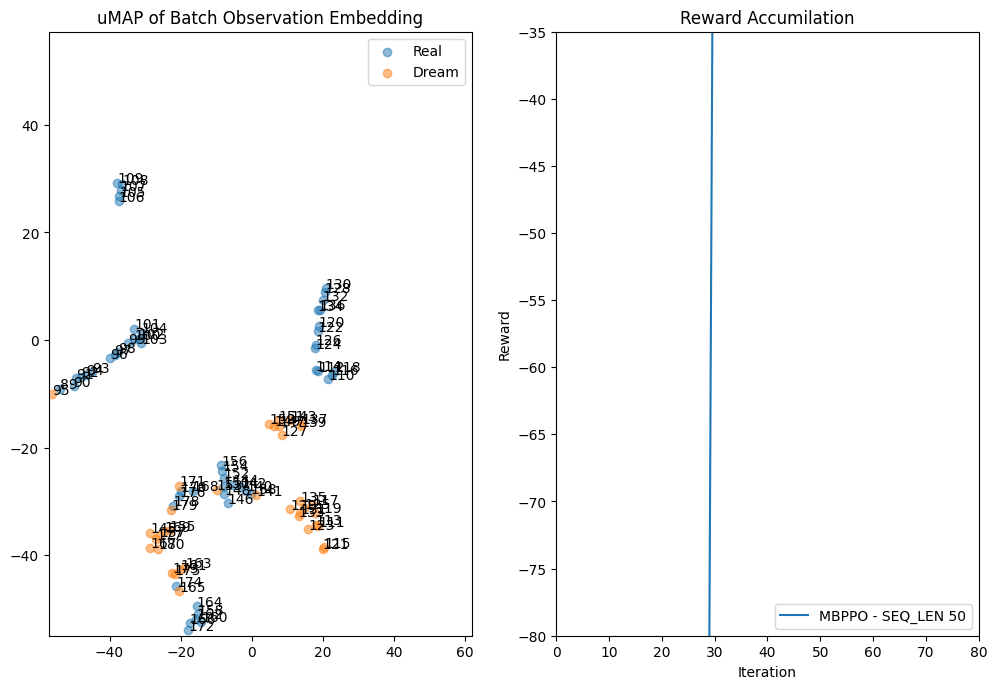

In [25]:

path = 'gagif'
if not os.path.exists('gagif'):
    os.mkdir(path)
#Comment out umap_embedding if adjusting plots after first run, its non-determeisitic 

obs_based_reward = np.load('mbppo_40_meander_invalids0.npy')

dream_pnt = 0; real_pnt = 0
filenames = []
fig = plt.figure(figsize=(12, 8), dpi=100)

ax = plt.subplot(1, 2, 1)
ax.set_xlim([embedding[:,0].min()-2,embedding[:,0].max()+2])
ax.set_ylim([embedding[:,1].min()-2,embedding[:,1].max()+2]) 
ax.set_title('uMAP of Batch Observation Embedding')
ax1 = plt.subplot(1, 2, 2)
ax1.set_xlim([0,80])
ax1.set_ylim([-80,-35])
ax1.set_title('Reward Accumilation')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Reward')
ax1.plot(obs_based_reward, label="MBPPO - SEQ_LEN 50")
#ax1.plot(evals_ppo[:i_line+1], label="PPO - Evaluation")
ax1.legend(loc='lower right')


ax.scatter(embedding[real_map_array][:,0], embedding[real_map_array][:,1], alpha=0.5, label = 'Real')
ax.scatter(embedding[dream_map_array][:,0], embedding[dream_map_array][:,1], alpha=0.5, label = 'Dream')
ax.set_xlim([np.min(embedding[:,0])-1,np.max(embedding[:,0])+1])
ax.set_ylim([np.min(embedding[:,1])-1,np.max(embedding[:,1])+1])
ax.legend()

for i, txt in enumerate(dream_map_array):
    ax.annotate(txt, (embedding[dream_map_array][i,0], embedding[dream_map_array][i,1]))

for i, txt in enumerate(real_map_array):
    ax.annotate(txt, (embedding[real_map_array][i,0], embedding[real_map_array][i,1]))


In [ ]:
np.arange(4,91,step=7)

array([ 4, 11, 18, 25, 32, 39, 46, 53, 60, 67, 74, 81, 88])

In [ ]:
from ray.rllib.utils.replay_buffers import ReplayBuffer, StorageUnit 
from ray.rllib.policy.sample_batch import SampleBatch 

buffer = ReplayBuffer(capacity=100)
dummy_batch = SampleBatch({"a": np.arange(100)})
buffer.add(dummy_batch)
s = buffer.sample(100)['a']
s
#for i in range(100):
#    print(np.where(s==i))

array([93, 19,  4, 92, 20, 81, 42, 21, 70, 51, 35,  6, 26, 37, 33, 93, 33,
       77, 80,  7, 27, 46, 23, 47, 59, 57, 26, 57, 31, 77,  7, 67,  9, 20,
       21, 94, 99, 73, 35, 25, 66, 13, 91, 31, 62, 23, 47, 98, 71, 68, 55,
       20, 80,  3, 60, 31,  5, 29, 24, 86, 71, 14, 36, 57, 34, 23, 53, 19,
       38, 62, 34, 68,  3, 23, 18, 92, 73,  4, 31,  6, 47, 60, 97, 35, 87,
        0, 13, 80, 94, 85,  4, 44,  3, 86,  1,  1, 58, 62,  7, 13])

In [ ]:
dream =  np.load('random_walks_dream.npy').mean(axis=1)
real = np.load('random_walks_real.npy').mean(axis=1)
print('Spread from Dream:')
cate = ['exploit', 'scan', 'no_activity', 'privileged', 'user', 'unknown', 'no comp']
a = dream.mean(axis=0)
for i in range(7):
    print(cate[i], np.mean(np.abs(a[np.arange(i,91,step=7)])))

Spread from Dream:
exploit 0.004538461538461539
scan 0.03746153846153847
no_activity 0.9580000000000001
privileged 0.059807692307692326
user 0.05492307692307692
unknown 0.036000000000000004
no comp 0.8492692307692309


In [ ]:
print('Spread from real:')
cate = ['exploit', 'scan', 'no_activity', 'privileged', 'user', 'unknown', 'no comp']
a = real.mean(axis=0)
for i in range(7):
    print(cate[i], np.mean(np.abs(a[np.arange(i,91,step=7)])))

Spread from real:
exploit 0.003800000000000002
scan 0.042815384615384595
no_activity 0.9533846153846155
privileged 0.0998923076923077
user 0.0687923076923077
unknown 0.10006923076923079
no comp 0.7312461538461539


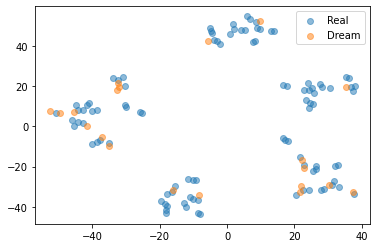

In [ ]:
dream =  np.load('random_walks_dream.npy').mean(axis=1)
real = np.load('random_walks_real.npy').mean(axis=1)
all = np.concatenate([dream, real], axis=0)

embedding = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(all)

plt.scatter(embedding[:100][:,0], embedding[:100][:,1], alpha=0.5, label = 'Real')
plt.scatter(embedding[100:][:,0], embedding[100:][:,1], alpha=0.5, label = 'Dream')
plt.legend()

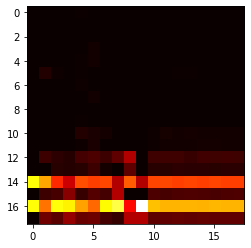

In [ ]:

plt.imshow(np.load('reward_matrix_lstm.npy'), cmap='hot', interpolation='nearest')

In [ ]:
reward_to_index = np.load('/home/adamprice/u75a-Data-Efficient-Decisions/CybORG/CybORG/MBPPO/reward_to_index.npy', allow_pickle=True).item()
index_to_reward = np.load('/home/adamprice/u75a-Data-Efficient-Decisions/CybORG/CybORG/MBPPO/index_to_reward.npy', allow_pickle=True).item()

In [ ]:
index_to_reward[reward_to_index[-0.10000000149011612]]

-0.10000000149011612

In [ ]:
data_path = '/home/adamprice/u75a-Data-Efficient-Decisions/CybORG/CybORG/Notebooks/logs/PPO/no_decoy_200000/data_seqence_50'
state = np.load(data_path + '/states.npy')
rewards = np.load(data_path + '/rewards.npy')

labels, encoding = np.unique(rewards, return_inverse=True)
index_to_reward = {}; reward_to_index = {}
for i in range(labels.shape[0]):
    index_to_reward[i] = labels[i]
    reward_to_index[labels[i]] = i

reward_classes = np.vectorize(reward_to_index.get)(rewards)
reward_onehot = np.eye(int(len(reward_to_index.keys())))[reward_classes]
print(reward_onehot.mean(axis=0))

[2.02020202e-04 1.31313131e-04 1.27777778e-03 7.42424242e-04
 3.19191919e-03 1.76767677e-03 7.42424242e-04 1.13131313e-03
 7.67676768e-04 8.33333333e-04 1.01818182e-02 9.28787879e-03
 5.41818182e-02 3.17222222e-02 3.08696970e-01 6.57373737e-02
 4.26106061e-01 8.32979798e-02]


In [ ]:
!pip install mpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 2.3 MB/s eta 0:00:00


In [ ]:
import mpu.ml
one_hot = mpu.ml.indices2one_hot(reward_classes, nb_classes=18)

In [ ]:
np.histogram(reward_classes, bins=np.arange(18))

(array([    40,     26,    253,    147,    632,    350,    147,    224,
           152,    165,   2016,   1839,  10728,   6281,  61122,  13016,
        100862]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]))

In [ ]:
encoding = np.zeros((2,13))
encoding[:,0] = 1
encoding

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
p = np.array([[0,1], [1,0]])
np.random.choice(np.arange(2), p=p)

ValueError: 'p' must be 1-dimensional